V2.0: Using stable Baselines

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import gym
from gym import spaces
from Data.data_retrieval import get_data
from Utils.add_features import add_fisher

Run Params

In [5]:
TICKER = ".NSEI"
INIT_NET_WORTH = 10000
HISTORICAL_STATES = 5
features = [
    # {"feature": "Close", "lookback": 0},
    # {"feature": "Fisher30", "lookback": 30},
    # {"feature": "Fisher60", "lookback": 60},
    {"feature": "Fisher20", "lookback": 20},
    {"feature": "Fisher5", "lookback": 5},
]
LR = 0.001
RANDOM_SEED = 11111
WINDOW = max([feature["lookback"] for feature in features])
train_percent = 0.8

# Data loading

In [6]:

if TICKER == 'COSINE':
    length = get_data('.NSEI', 'D').shape[0]
    df = pd.DataFrame({
        'High': np.sin(np.arange(length)/10.0) + np.random.normal(2, 0.01, size = (length, )) ,
        'Open': np.sin(np.arange(length)/10.0) + np.random.normal(2, 0.01, size = (length, )) ,
        'Close': np.sin(np.arange(length)/10.0) + np.random.normal(2, 0.01, size = (length, )) ,
        'Low': np.sin(np.arange(length)/10.0) + np.random.normal(2, 0.01, size = (length, )),
        'Volume': np.abs(np.sin(np.arange(length)/10.0)),
      }
      )
else:
    df = get_data(TICKER, 'D')


In [7]:
signal_features = pd.DataFrame(index = df.index)
for feature, lookback in [(feature["feature"], feature["lookback"]) for feature in features]:
    if feature=="Close":
        signal_features[feature] = df["Close"]
    if feature.startswith("Fisher"):
        signal_features[feature] = add_fisher([df, lookback])[f"Fisher{lookback}"]


In [8]:
train_df = df.iloc[:int(train_percent*len(df))].reset_index(drop=True)
test_df = df.iloc[int(train_percent*len(df)):].reset_index(drop=True)
train_signal_features = signal_features.iloc[:int(train_percent*len(signal_features))].reset_index(drop=True)
test_signal_features = signal_features.iloc[int(train_percent*len(signal_features)):].reset_index(drop=True)

# Environment

In [9]:
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.vec_env import DummyVecEnv

In [10]:
signal_features.shape

(3613, 2)

In [23]:
class StockTradingEnv(gym.Env):

    def __init__(self, df, features, init_account_balance, window_shape, random_start = False):
        # initialize environment
        super(StockTradingEnv, self).__init__()
        # raw dataset
        self.df = df
        # how much $ do we have?
        self.init_account_balance = init_account_balance
        self.balance = self.init_account_balance
        self.net_worth = self.init_account_balance

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.window_shape = window_shape
        self.action_space = spaces.Discrete(2)
        self.random_start = random_start

        # current step, starts with window size or random
        if not self.random_start:
            self.current_step = self.window_shape
        else:
            self.current_step = random.randint(self.window_shape, len(self.df) - self.window_shape)

        self.signal_features = features

        # process data initially
        self.process_data()

        # share costs
        self.in_position = False
        self.position_value = 0.0
        self.price_bought = 0.0
        self.bet_bought = 0.0

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = self.init_account_balance
        self.net_worth = self.init_account_balance
        if not self.random_start:
            self.current_step = self.window_shape
        else:
            self.current_step = random.randint(self.window_shape, len(self.df) - self.window_shape)
        self.in_position = False
        self.position_value = 0.0
        self.price_bought = 0.0
        self.bet_bought = 0.0
        return self.get_observation()

    def process_data(self):
        self.start, self.end = self.window_shape, len(self.df)
        self.prices = self.df.iloc[self.start:self.end]
        self.signal_features = self.signal_features.iloc[self.start:self.end]
        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
            low=-1, high=1, shape=(self.window_shape, self.signal_features.shape[-1]), dtype=np.float16
        )

    def get_observation(self):
        market_state = self.signal_features.iloc[self.current_step-self.window_shape:self.current_step]
        return market_state

    def step(self, action):
        self.take_action(action)
        self.current_step += 1

        if self.current_step > len(self.df) - self.window_shape:
            self.current_step = self.window_shape

        reward = self.net_worth

        done = False
        if (self.current_step >= (len(self.df) - self.window_shape)):  #(self.net_worth <= 0) or
            done = True

        obs = self.get_observation()
        return obs, reward, done, {}

    def take_action(self, action):

        # Set the current price to a random price within the time step
        current_price = self.df.iloc[self.current_step]["Close"]
        self.current_price = current_price
        self.datetime = self.df.iloc[self.current_step]["Datetime"]

        if not self.in_position:
            if action == 1: # OPEN LONG
                self.in_position = True
                self.price_bought = current_price
                self.bet_bought = self.balance
                self.balance -= self.bet_bought
                self.position_value = self.bet_bought
            else: # KEEP LOOKING
                pass
        else:
            market_return = ((current_price - self.price_bought) / self.price_bought)
            if action == 1: # HOLD LONG
                self.position_value = self.bet_bought * (1.0 + market_return)
            else: # CLOSE LONG
                self.balance += self.bet_bought * (1.0 + market_return)
                self.in_position = False
                self.price_bought = 0.0
                self.bet_bought = 0.0
                self.position_value = 0.0

        self.net_worth = self.balance + self.position_value

    def render(self, mode='human'):
        return {
            'step': self.current_step,
            'price': self.current_price,
            'balance': self.balance,
            'position': self.position_value,
            'net_worth': self.net_worth,
            'profit': self.net_worth - self.init_account_balance,
            'datetime': self.datetime
        }

In [24]:
train_df

,Close,Datetime,High,Low,Open,Volume
0,4494.65,2007-09-17,4549.05,4482.85,4518.45,5.125300e+10
1,4546.20,2007-09-18,4551.80,4481.55,4494.10,5.639100e+10
2,4732.35,2007-09-19,4739.00,4550.25,4550.25,1.085160e+11
3,4747.55,2007-09-20,4760.85,4721.15,4734.85,9.397000e+10
4,4837.55,2007-09-21,4855.70,4733.70,4752.95,1.613860e+11
...,...,...,...,...,...,...
2885,11737.90,2019-05-22,11784.80,11682.40,11727.95,3.558710e+11
2886,11657.05,2019-05-23,12041.15,11614.50,11901.30,5.690310e+11
2887,11844.10,2019-05-24,11859.00,11658.10,11748.00,3.746370e+11
2888,11924.75,2019-05-27,11957.15,11812.40,11855.50,3.483560e+11


In [25]:
N_TIME_STEPS = len(train_df) - HISTORICAL_STATES

In [26]:
# The algorithms require a vectorized environment to run
env_train = DummyVecEnv([lambda: StockTradingEnv(train_df, train_signal_features, INIT_NET_WORTH, HISTORICAL_STATES)])
model = A2C('MlpPolicy', env_train, verbose=1, learning_rate=LR, seed=RANDOM_SEED)
model.learn(total_timesteps=N_TIME_STEPS, log_interval=100)

Using cpu device
-------------------------------------
| time/                 |           |
|    fps                | 498       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -0.691    |
|    explained_variance | -5.01e-06 |
|    learning_rate      | 0.001     |
|    n_updates          | 99        |
|    policy_loss        | 2.85e+04  |
|    value_loss         | 2.07e+09  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.673   |
|    explained_variance | 2.29e-05 |
|    learning_rate      | 0.001    |
|    n_updates          | 199      |
|    policy_loss        | 1.88e+04 |
|    va

# In-sample evaluation

In [27]:
def evaluate_agent(env, df, model):
    obs = env.reset()
    history = {
        'balance': [],
        'action': [],
        'position': [],
        'net_worth': [],
        'price': [],
        'datetime': []

    }

    for i in range(len(df) - HISTORICAL_STATES):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        if done[0] == True:
            break
        state = env.render()
        history['action'].append(action[0])
        history['balance'].append(state['balance'])
        history['net_worth'].append(state['net_worth'])
        history['position'].append(state['position'])
        history['price'].append(state['price'])
        history['datetime'].append(state['datetime'])

    actions_over_time = np.array(history['action'])
    return history, actions_over_time

In [28]:
history, actions_over_time = evaluate_agent(env_train, train_df, model)

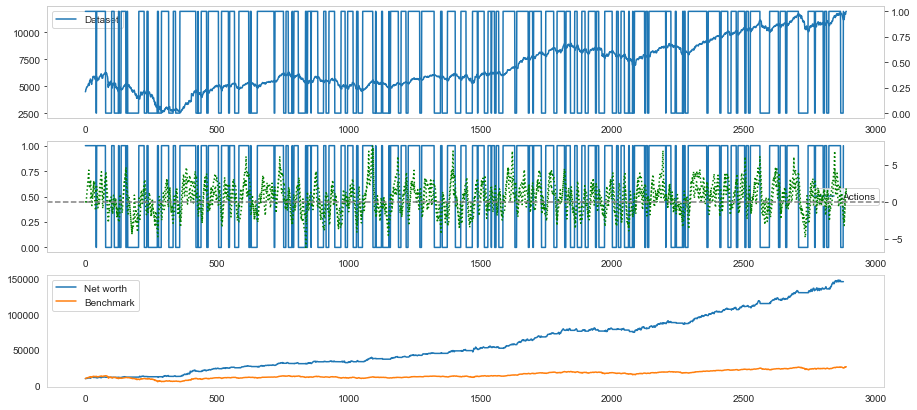

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))
ax1.plot(train_df['Close'].values, label = 'Dataset')
ax1_copy = ax1.twinx()
ax1_copy.plot(actions_over_time.flatten(), label = 'Actions')
ax2.plot(actions_over_time.flatten(), label = 'Actions')
ax2_copy = ax2.twinx()
train_features = train_signal_features
for feature in [feature["feature"] for feature in features]:
    ax2_copy.plot(train_features[feature].values, label = feature, color = 'green', ls = 'dotted')
ax2_copy.axhline(0.0, ls = '--', color = 'grey')

ax3.plot(np.array(history['net_worth']), label = 'Net worth')
ax3.plot((train_df['Close']*INIT_NET_WORTH/train_df['Close'].iloc[0]).values, label = 'Benchmark')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

# Evaluation single holdout out-of-sample

In [30]:
env_test = DummyVecEnv([lambda: StockTradingEnv(test_df, test_signal_features, INIT_NET_WORTH, HISTORICAL_STATES)])
history_test, actions_over_time_test = evaluate_agent(env_test, test_df, model)

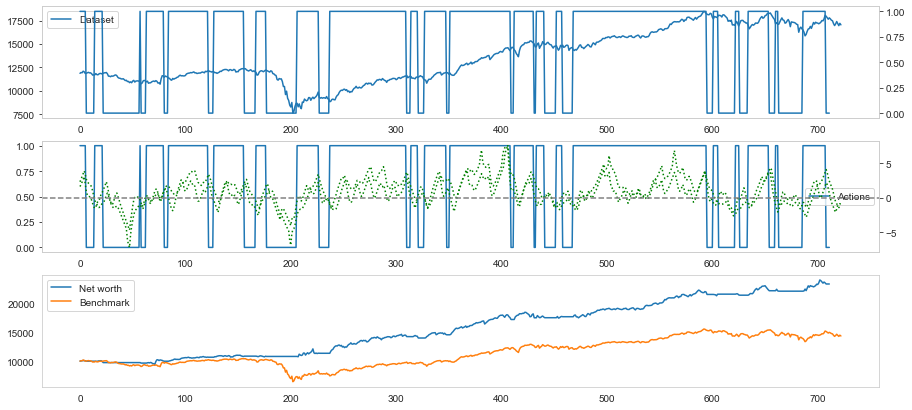

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))
ax1.plot(test_df['Close'], label = 'Dataset')
ax1_copy = ax1.twinx()
ax1_copy.plot(actions_over_time_test.flatten(), label = 'Actions')
ax2.plot(actions_over_time_test.flatten(), label = 'Actions')
ax2_copy = ax2.twinx()
for feature in [feature["feature"] for feature in features]:
    ax2_copy.plot(test_signal_features[feature].values, label = feature, color = 'green', ls = 'dotted')
ax2_copy.axhline(0.0, ls = '--', color = 'grey')
ax3.plot(np.array(history_test['net_worth']), label = 'Net worth')
ax3.plot((test_df['Close']*INIT_NET_WORTH/test_df['Close'].iloc[0]).values, label = 'Benchmark')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

In [35]:
pd.DataFrame(history_test)["datetime"]

0     2019-06-06
1     2019-06-07
2     2019-06-10
3     2019-06-11
4     2019-06-12
         ...    
707   2022-04-11
708   2022-04-12
709   2022-04-13
710   2022-04-18
711   2022-04-19
Name: datetime, Length: 712, dtype: datetime64[ns]